## langgraph tool-node, conditional-edge, loop

### Instalacja bibliotek

In [37]:
!pip install -q langgraph langchain langchain-openai python-dotenv


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [38]:
from dotenv import load_dotenv
load_dotenv()

from typing import TypedDict

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

#  Model LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Definicja stanu

In [39]:
class State(TypedDict):
    question: str
    llm_answer: str
    is_correct: bool

### Węzeł LLM

In [40]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Jesteś pomocnym asystentem matematycznym. Odpowiadaj tylko Resultiem liczbowym."),
    ("user", "{question}")
])

def ask_llm(state: State) -> State:
    response = (prompt | llm).invoke({"question": state["question"]})
    return {"llm_answer": response.content, "is_correct": False}

### Węzeł z narzędziem

In [41]:
def tool_calc(state: State) -> State:
    try:
        correct = eval(state["question"])
        user_answer = int(state["llm_answer"])
        return {"is_correct": (correct == user_answer)}
    except:
        return {"is_correct": False}

### Węzeł końcowy

In [42]:
def finish(state: State) -> State:
    if state["is_correct"]:
        print(f"✅ Poprawna odpowiedź: {state['llm_answer']}")
    else:
        print("❌ Nie udało się uzyskać poprawnej odpowiedzi.")
    return state

### Uruchomienie grafu

In [43]:
graph = StateGraph(State)

graph.add_node("ask_llm", ask_llm)
graph.add_node("tool_calc", tool_calc)
graph.add_node("finish", finish)

graph.set_entry_point("ask_llm")
graph.add_edge("ask_llm", "tool_calc")

#  Warunek: jeśli poprawna -> finish, jeśli nie -> znowu ask_llm
def check_answer(state: State):
    return "finish" if state["is_correct"] else "ask_llm"

graph.add_conditional_edges("tool_calc", check_answer, ["finish", "ask_llm"])
graph.add_edge("finish", END)

app = graph.compile()

In [44]:
app.invoke({"question": "16 * 12"})

✅ Poprawna odpowiedź: 192


{'question': '16 * 12', 'llm_answer': '192', 'is_correct': True}

### Wizualizacja grafu

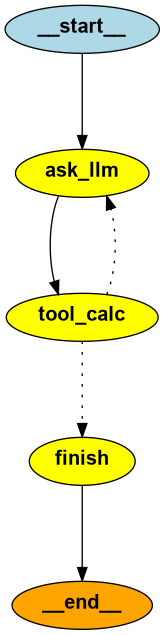

In [45]:
from IPython.display import Image, display

png_bytes = app.get_graph().draw_png()
display(Image(png_bytes))